**1. Mean Shift Algorithm**

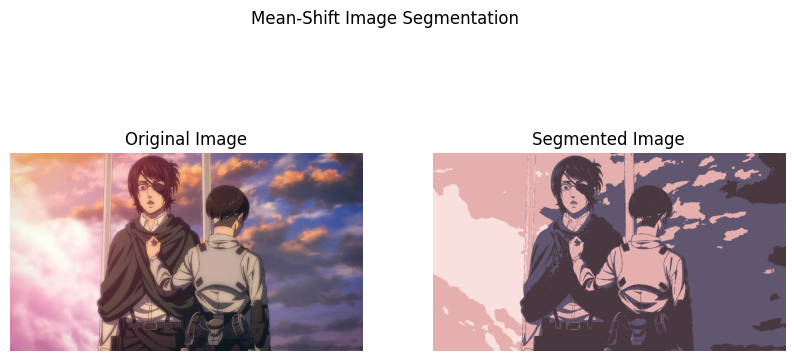

In [ ]:
# Importing the necessary libraries
from sklearn.cluster import MeanShift, estimate_bandwidth
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Reading the input image
image_path = "aot.jpg"  # Replace with your image path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Reshaping the image to a 2D array of pixels
flat_image = image.reshape((-1, 3))

# Estimating bandwidth for MeanShift
bandwidth = estimate_bandwidth(flat_image, quantile=0.1, n_samples=500)

# Applying Mean-Shift clustering
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(flat_image)

# Extracting labels and cluster centers
labels = ms.labels_
cluster_centers = ms.cluster_centers_

# Reconstructing the segmented image
segmented_image = cluster_centers[labels].reshape(image.shape).astype(np.uint8)

# Plotting the original and segmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Segmented Image")
plt.axis("off")

plt.suptitle("Mean-Shift Image Segmentation")
plt.show()


**2. K-Means Clustering**

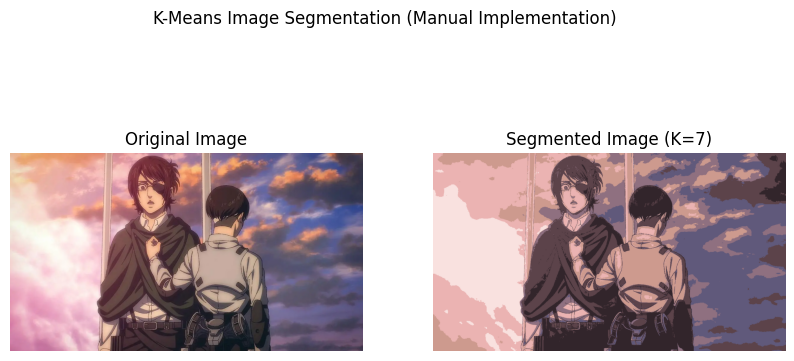

In [ ]:
# Reshaping the image to a 2D array of pixels
pixels = image.reshape((-1, 3))
pixels = np.float32(pixels)

# Parameters
K = 7  # Number of clusters (adjust as needed)
max_iterations = 100
tolerance = 1e-4

# Step 1: Initialize cluster centers randomly
centers = pixels[np.random.choice(pixels.shape[0], K, replace=False)]

# Function to compute the distance between points and centers
def compute_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2, axis=1))

# Step 2: K-Means clustering manually
for iteration in range(max_iterations):
    # Step 3: Assign each point to the nearest cluster center
    distances = np.array([compute_distance(pixels, center) for center in centers])
    labels = np.argmin(distances, axis=0)

    # Step 4: Update cluster centers as the mean of assigned points
    new_centers = np.array([pixels[labels == k].mean(axis=0) if np.any(labels == k) else centers[k] for k in range(K)])

    # Check for convergence (if centers do not change significantly)
    if np.all(np.linalg.norm(new_centers - centers, axis=1) < tolerance):
        break
    centers = new_centers

# Step 5: Reconstruct the segmented image
segmented_pixels = centers[labels].astype(np.uint8)
segmented_image = segmented_pixels.reshape(image.shape)

# Plotting the original and segmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title(f"Segmented Image (K={K})")
plt.axis("off")

plt.suptitle("K-Means Image Segmentation (Manual Implementation)")
plt.show()


**3. Thresholding**

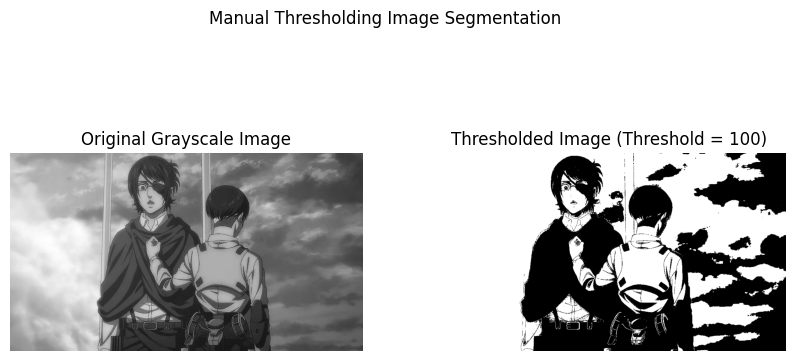

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

# Manually setting a threshold value
threshold_value = 100 # Adjust as needed (0-255)

# Manual thresholding: Binary segmentation
binary_image = np.where(gray > threshold_value, 255, 0).astype(np.uint8)

# Plotting the original and thresholded images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.title(f"Thresholded Image (Threshold = {threshold_value})")
plt.axis("off")

plt.suptitle("Manual Thresholding Image Segmentation")
plt.show()

**4. Graph Cut Segmentation**

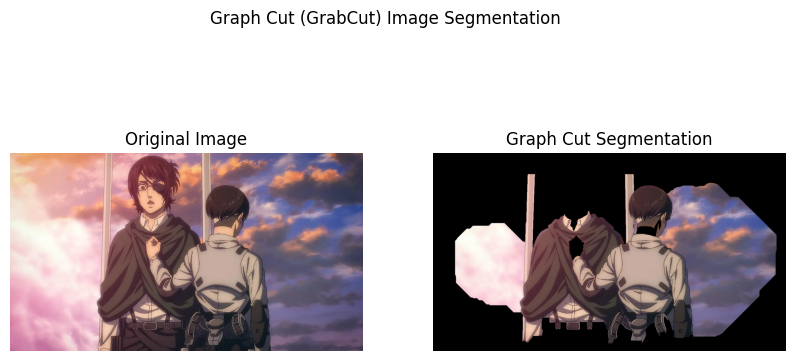

In [ ]:
mask = np.zeros(image.shape[:2], np.uint8)

# Creating background and foreground models (required by GrabCut)
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)

# Defining a rectangle for the initial foreground region (manually)
rect = (75, 75, image.shape[1] - 100, image.shape[0] - 100)  # Adjust as needed

# Applying GrabCut algorithm (Graph Cut)
cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

# Modifying the mask: setting background and probable background to 0, others to 1
mask_2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# Applying the mask to the original image
segmented_image = image * mask_2[:, :, np.newaxis]

# Plotting the original and segmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Graph Cut Segmentation")
plt.axis("off")

plt.suptitle("Graph Cut (GrabCut) Image Segmentation")
plt.show()

**5. Region Growing**

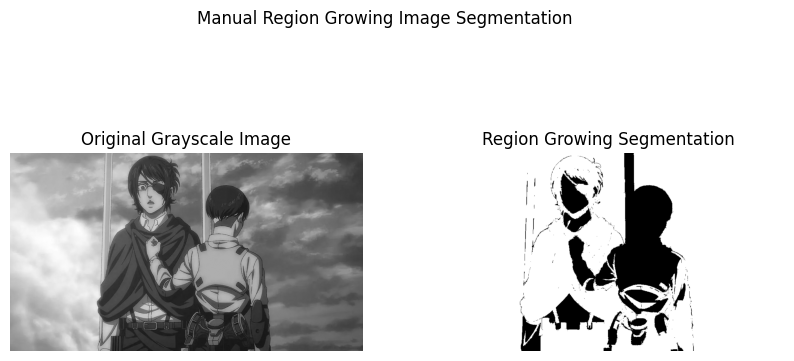

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

# Seed point (manually chosen or based on some criteria)
seed_point = (100, 100)  # Adjust as needed
threshold = 10 # Threshold for similarity (intensity difference)

# Creating an empty mask for the segmented region
segmented = np.zeros_like(gray, dtype=np.uint8)

# Creating a list of points to be processed
to_process = [seed_point]

# Region Growing Algorithm
while to_process:
    x, y = to_process.pop(0)  # Get the current point
    # Check if the point is within image boundaries and not processed yet
    if segmented[y, x] == 0:
        # Mark the point as processed
        segmented[y, x] = 255

        # Check the 8-connected neighborhood
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1), (-1, 1), (1, -1)]:
            nx, ny = x + dx, y + dy
            # Ensure the neighbor is within bounds
            if 0 <= nx < gray.shape[1] and 0 <= ny < gray.shape[0]:
                # Check similarity condition
                if segmented[ny, nx] == 0 and abs(int(gray[ny, nx]) - int(gray[y, x])) < threshold:
                    to_process.append((nx, ny))

# Plotting the original and segmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmented, cmap='gray')
plt.title("Region Growing Segmentation")
plt.axis("off")

plt.suptitle("Manual Region Growing Image Segmentation")
plt.show()